# 🏴‍☠️ AN2DL25 Challenge 1 — Pirate Pain Classification

This notebook implements a full deep-learning pipeline for multivariate time-series classification of the Pirate Pain dataset. It is inspired by the Lecture 4 notebook (`Timeseries Classification (1).ipynb`) but adapted for the competition setting, including data preparation, model training (RNN/GRU/LSTM variants), evaluation, and test-time inference.



In [1]:
# %%capture
# !pip install -q -r requirements.txt




In [ ]:
import os
import random
import math
import copy
from pathlib import Path
from typing import Tuple, Dict, Optional, List
from datetime import datetime
from itertools import product
import inspect

import numpy as np
import pandas as pd
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

try:
    from torch.amp import autocast, GradScaler
except ImportError:  # pragma: no cover
    from torch.cuda.amp import autocast, GradScaler



In [3]:
SEED = 42

try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:  # pragma: no cover
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=False)
    BASE_DIR = Path('/content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge')
else:
    BASE_DIR = Path('/Users/md101ta/Desktop/Pirates')

DATA_DIR = (BASE_DIR / 'data').resolve()
OUTPUT_DIR = (BASE_DIR / 'outputs').resolve()
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    DEVICE = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    DEVICE = torch.device('cpu')

print(f'Running in Colab: {IN_COLAB}')
print(f'Device: {DEVICE}')
print(f'Data dir: {DATA_DIR}')
print(f'Output dir: {OUTPUT_DIR}')

_AUTocast_params = inspect.signature(autocast).parameters
_GRADSCALER_PARAMS = inspect.signature(GradScaler).parameters

def autocast_context():
    enabled = DEVICE.type == 'cuda'
    if 'device_type' in _AUTocast_params:
        return autocast(device_type=DEVICE.type, enabled=enabled)
    if 'device' in _AUTocast_params:
        return autocast(DEVICE.type, enabled=enabled)
    # fallback to legacy signature (enabled only)
    return autocast(enabled=enabled)


def create_grad_scaler():
    enabled = DEVICE.type == 'cuda'
    if 'device_type' in _GRADSCALER_PARAMS:
        return GradScaler(device_type=DEVICE.type, enabled=enabled)
    return GradScaler(enabled=enabled)


<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2583850707.py:11: SyntaxWarning: invalid escape sequence '\ '
  BASE_DIR = Path('/content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge')


Mounted at /content/drive
Running in Colab: True
Device: cuda
Data dir: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/data
Output dir: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs


In [4]:
LOG_DIR = (OUTPUT_DIR / 'logs').resolve()
CHECKPOINT_DIR = (OUTPUT_DIR / 'checkpoints').resolve()
LOG_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)



In [5]:
from pathlib import Path
import pandas as pd
from typing import Tuple

# Percorso al dataset su Google Drive
DATA_DIR = Path('/content/drive/MyDrive/[2025-2026] AN2DL/Challenge')

def load_data(data_dir: Path) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train = pd.read_csv(data_dir / 'pirate_pain_train.csv')
    y_train = pd.read_csv(data_dir / 'pirate_pain_train_labels.csv')
    X_test  = pd.read_csv(data_dir / 'pirate_pain_test.csv')
    return X_train, y_train, X_test

# Carica i dati
X_train_raw, y_train, X_test_raw = load_data(DATA_DIR)
print(X_train_raw.shape, y_train.shape, X_test_raw.shape)




(105760, 40) (661, 2) (211840, 40)


Time steps: 160 | Features: 38 | Classes: 3
Category mappings: {'n_legs': {'one+peg_leg': 0, 'two': 1}, 'n_hands': {'one+hook_hand': 0, 'two': 1}, 'n_eyes': {'one+eye_patch': 0, 'two': 1}}


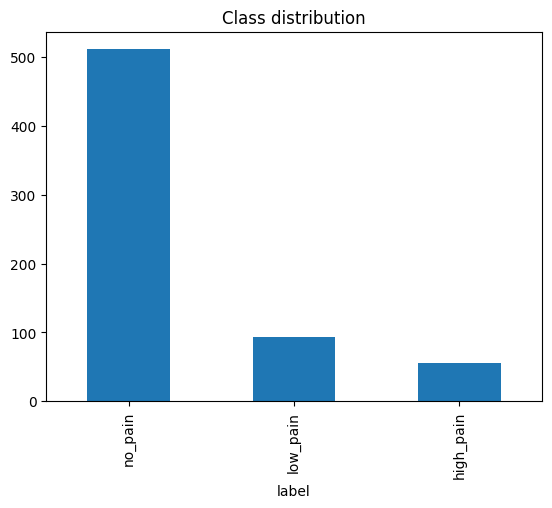

In [ ]:
CATEGORICAL_COLUMNS = ['n_legs', 'n_hands', 'n_eyes']
CATEGORY_MAPPINGS: Dict[str, Dict[str, int]] = {}

for col in CATEGORICAL_COLUMNS:
    uniques = pd.concat([X_train_raw[col], X_test_raw[col]]).dropna().unique()
    mapping = {value: idx for idx, value in enumerate(sorted(uniques))}
    CATEGORY_MAPPINGS[col] = mapping
    X_train_raw[col] = X_train_raw[col].map(mapping).astype(np.int32)
    X_test_raw[col] = X_test_raw[col].map(mapping).astype(np.int32)

survey_columns = [col for col in X_train_raw.columns if col.startswith('pain_survey')]
joint_columns = [col for col in X_train_raw.columns if col.startswith('joint_')]
numeric_columns = survey_columns + joint_columns

survey_scaler = StandardScaler()
joint_scaler = StandardScaler()

X_train_raw.loc[:, survey_columns] = survey_scaler.fit_transform(X_train_raw[survey_columns])
X_test_raw.loc[:, survey_columns] = survey_scaler.transform(X_test_raw[survey_columns])
X_train_raw.loc[:, joint_columns] = joint_scaler.fit_transform(X_train_raw[joint_columns])
X_test_raw.loc[:, joint_columns] = joint_scaler.transform(X_test_raw[joint_columns])

FEATURE_COLUMNS = [col for col in X_train_raw.columns if col not in ['sample_index', 'time']]
TIME_STEPS = X_train_raw['time'].nunique()
NUM_FEATURES = len(FEATURE_COLUMNS)
NUM_CLASSES = y_train['label'].nunique()
print(f'Time steps: {TIME_STEPS} | Features: {NUM_FEATURES} | Classes: {NUM_CLASSES}')
print('Category mappings:', CATEGORY_MAPPINGS)

y_train['label'].value_counts().plot(kind='bar', title='Class distribution')
plt.show()



/tmp/ipython-input-1314220990.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


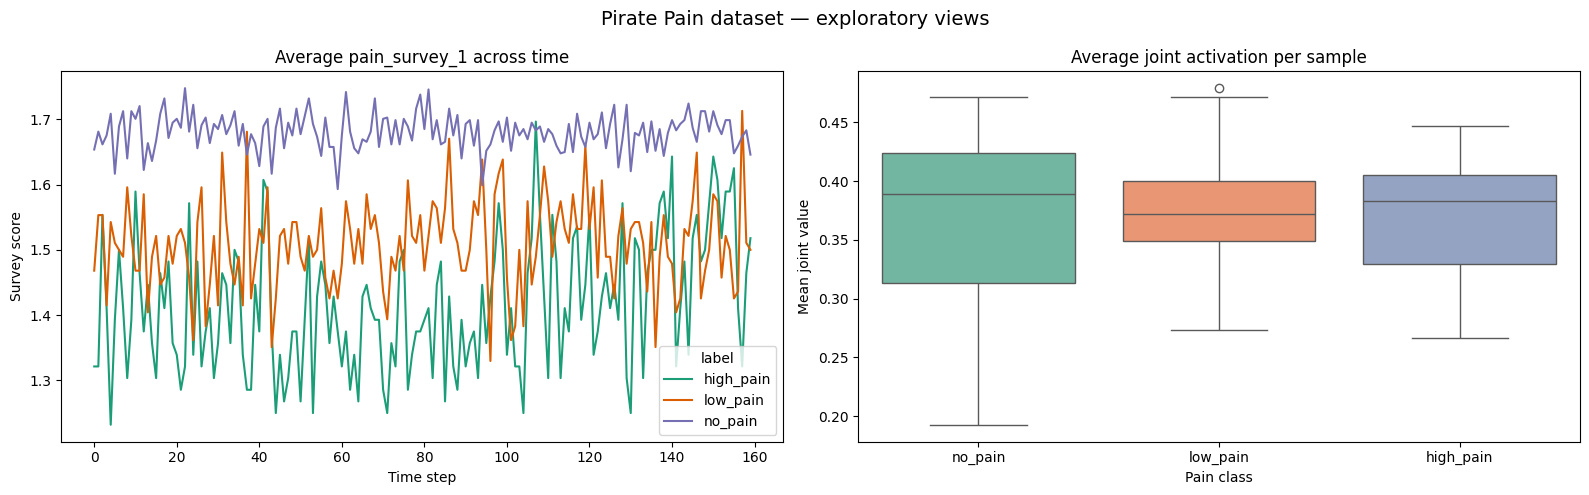

In [7]:
# Exploratory data analysis plots
train_with_labels = X_train_raw.merge(y_train, on='sample_index')

survey_columns = [col for col in X_train_raw.columns if col.startswith('pain_survey')]
joint_columns = [col for col in X_train_raw.columns if col.startswith('joint_')]

# Mean survey trajectory per class
survey_time_mean = (
    train_with_labels[['time', 'label'] + survey_columns]
    .groupby(['label', 'time'])[survey_columns]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(
    data=survey_time_mean,
    x='time',
    y=survey_columns[0],
    hue='label',
    palette='Dark2',
    ax=axes[0],
)
axes[0].set_title(f"Average {survey_columns[0]} across time")
axes[0].set_ylabel('Survey score')
axes[0].set_xlabel('Time step')

# Distribution of joint activation per class (average across joints and time)
sample_joint_mean = (
    train_with_labels.groupby(['sample_index', 'label'])[joint_columns]
    .mean()
    .reset_index()
)
sample_joint_mean['mean_joint_activation'] = sample_joint_mean[joint_columns].mean(axis=1)

sns.boxplot(
    data=sample_joint_mean,
    x='label',
    y='mean_joint_activation',
    palette='Set2',
    ax=axes[1],
)
axes[1].set_title('Average joint activation per sample')
axes[1].set_xlabel('Pain class')
axes[1].set_ylabel('Mean joint value')

plt.suptitle('Pirate Pain dataset — exploratory views', fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
def compute_joint_statistics(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    agg = df.groupby('sample_index')[columns].agg(['mean', 'std', 'max', 'min'])
    agg.columns = [f"{col}_{stat}" for col, stat in agg.columns]
    agg = agg.fillna(0.0)

    std_cols = [c for c in agg.columns if c.endswith('_std')]
    max_cols = [c for c in agg.columns if c.endswith('_max')]
    min_cols = [c for c in agg.columns if c.endswith('_min')]

    agg['joint_var_over_time'] = agg[std_cols].mean(axis=1)
    agg['joint_range'] = (agg[max_cols].values - agg[min_cols].values).mean(axis=1)
    return agg


def compute_survey_context(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    return df.groupby('sample_index')[columns].mean()


train_joint_stats = compute_joint_statistics(X_train_raw, joint_columns)
test_joint_stats = compute_joint_statistics(X_test_raw, joint_columns)

train_survey_context = compute_survey_context(X_train_raw, survey_columns)
test_survey_context = compute_survey_context(X_test_raw, survey_columns)

train_context_df = pd.concat([train_survey_context, train_joint_stats], axis=1).sort_index().fillna(0.0)
test_context_df = pd.concat([test_survey_context, test_joint_stats], axis=1).sort_index().fillna(0.0)

context_scaler = StandardScaler()
context_scaler.fit(train_context_df)

CONTEXT_FEATURES = train_context_df.shape[1]
print(f'Context features: {CONTEXT_FEATURES}')



In [ ]:
LABEL2IDX = {label: idx for idx, label in enumerate(sorted(y_train['label'].unique()))}
IDX2LABEL = {idx: label for label, idx in LABEL2IDX.items()}
print('Label mapping:', LABEL2IDX)


def pivot_timeseries(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    pivoted = (
        df.pivot(index='sample_index', columns='time', values=FEATURE_COLUMNS)
          .sort_index(axis=0)
          .sort_index(axis=1, level=1)
    )
    data = pivoted.to_numpy().reshape(-1, TIME_STEPS, NUM_FEATURES).astype(np.float32)
    sample_ids = pivoted.index.to_numpy()
    return data, sample_ids


X_train_np, train_sample_ids = pivot_timeseries(X_train_raw)
X_test_np, test_sample_ids = pivot_timeseries(X_test_raw)

train_context_np = context_scaler.transform(train_context_df.loc[train_sample_ids]).astype(np.float32)
test_context_np = context_scaler.transform(test_context_df.loc[test_sample_ids]).astype(np.float32)

y_train_idx = (
    y_train.set_index('sample_index')
    .loc[train_sample_ids]['label']
    .map(LABEL2IDX)
    .to_numpy()
)

print(X_train_np.shape, train_context_np.shape, y_train_idx.shape, X_test_np.shape, test_context_np.shape)

CLASS_COUNTS = np.bincount(y_train_idx, minlength=NUM_CLASSES)
CLASS_WEIGHTS = 1.0 / np.sqrt(CLASS_COUNTS)
CLASS_WEIGHTS = (CLASS_WEIGHTS / CLASS_WEIGHTS.mean())
CLASS_WEIGHT_DICT = {IDX2LABEL[idx]: weight for idx, weight in enumerate(CLASS_WEIGHTS)}
print('Class counts:', dict(zip([IDX2LABEL[i] for i in range(NUM_CLASSES)], CLASS_COUNTS)))
print('Class weights (balanced):', CLASS_WEIGHT_DICT)



Label mapping: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
(661, 160, 38) (661,) (1324, 160, 38)
Class counts: {'high_pain': np.int64(56), 'low_pain': np.int64(94), 'no_pain': np.int64(511)}
Class weights (balanced): {'high_pain': np.float64(1.426609948295241), 'low_pain': np.float64(1.1011217341256143), 'no_pain': np.float64(0.4722683175791445)}


In [164]:
def compute_normalization_stats(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # data shape: (N, T, F)
    mean = data.reshape(-1, NUM_FEATURES).mean(axis=0)
    std = data.reshape(-1, NUM_FEATURES).std(axis=0) + 1e-6
    return mean, std


def normalize(data: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (data - mean) / std


feat_mean, feat_std = compute_normalization_stats(X_train_np)
X_train_np = normalize(X_train_np, feat_mean, feat_std)
X_test_np = normalize(X_test_np, feat_mean, feat_std)



In [ ]:
def make_dataloader_from_arrays(
    X: np.ndarray,
    context: np.ndarray,
    y: Optional[np.ndarray],
    batch_size: int,
    shuffle: bool,
    *,
    class_weights: Optional[np.ndarray] = None,
    use_weighted_sampler: bool = False,
) -> DataLoader:
    dataset = TimeSeriesDataset(X, context, y)
    if use_weighted_sampler and y is not None and class_weights is not None:
        sample_weights = class_weights[y]
        sampler = WeightedRandomSampler(
            weights=torch.from_numpy(sample_weights).double(),
            num_samples=len(sample_weights),
            replacement=True,
        )
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler, drop_last=False)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)



In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: np.ndarray,
        context: np.ndarray,
        labels: Optional[np.ndarray] = None,
    ):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.context = torch.tensor(context, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)

    def __len__(self) -> int:
        return self.data.shape[0]

    def __getitem__(self, idx: int):
        series = self.data[idx]
        context = self.context[idx]
        if self.labels is None:
            return series, context
        return series, context, self.labels[idx]



In [ ]:
def create_dataloaders(
    X: np.ndarray,
    y: np.ndarray,
    context: np.ndarray,
    valid_size: float = 0.2,
    batch_size: int = 64,
):
    X_train, X_valid, y_train, y_valid, ctx_train, ctx_valid = train_test_split(
        X,
        y,
        context,
        test_size=valid_size,
        random_state=SEED,
        stratify=y,
    )

    train_loader = make_dataloader_from_arrays(
        X_train,
        ctx_train,
        y_train,
        batch_size=batch_size,
        shuffle=False,
        class_weights=CLASS_WEIGHTS,
        use_weighted_sampler=True,
    )
    valid_loader = make_dataloader_from_arrays(
        X_valid,
        ctx_valid,
        y_valid,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, valid_loader, (X_train, y_train, ctx_train, X_valid, y_valid, ctx_valid)


BATCH_SIZE = 64
train_loader, valid_loader, (X_train_split, y_train_split, ctx_train_split, X_valid_split, y_valid_split, ctx_valid_split) = create_dataloaders(
    X_train_np,
    y_train_idx,
    train_context_np,
    batch_size=BATCH_SIZE,
)



In [ ]:
class RecurrentBackbone(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
        rnn_type: str = 'lstm',
        bidirectional: bool = True,
        context_size: int = 0,
    ):
        super().__init__()
        rnn_cls = {
            'rnn': nn.RNN,
            'gru': nn.GRU,
            'lstm': nn.LSTM,
        }[rnn_type.lower()]
        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional
        self.context_size = context_size
        self.rnn = rnn_cls(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional,
        )
        proj_input = hidden_size * (2 if bidirectional else 1)
        head_input = proj_input + context_size
        self.context_norm = nn.LayerNorm(context_size) if context_size > 0 else None
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(head_input, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, NUM_CLASSES),
        )

    def forward(self, x, context: Optional[torch.Tensor] = None):
        out, _ = self.rnn(x)
        # use last time-step hidden state
        last = out[:, -1, :]
        if self.context_size > 0 and context is not None:
            if self.context_norm is not None:
                context = self.context_norm(context)
            last = torch.cat([last, context], dim=-1)
        return self.head(last)



In [ ]:
def compute_classification_metrics(preds: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    accuracy = float((preds == targets).mean())
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets,
        preds,
        average='macro',
        zero_division=0,
    )
    return {
        'accuracy': accuracy,
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: GradScaler,
    max_grad_norm: float = 5.0,
) -> Tuple[float, Dict[str, float]]:
    model.train()
    running_loss = 0.0
    preds_all, targets_all = [], []

    for series, context, targets in loader:
        series = series.to(DEVICE)
        context = context.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with autocast_context():
            logits = model(series, context)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        if max_grad_norm is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * series.size(0)
        preds_all.append(torch.argmax(logits.detach(), dim=1).cpu())
        targets_all.append(targets.cpu())

    preds_np = torch.cat(preds_all).numpy()
    targets_np = torch.cat(targets_all).numpy()
    metrics = compute_classification_metrics(preds_np, targets_np)
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, metrics


def evaluate_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
) -> Tuple[float, Dict[str, float], np.ndarray, np.ndarray]:
    model.eval()
    running_loss = 0.0
    preds_all, targets_all = [], []

    with torch.no_grad():
        for series, context, targets in loader:
            series = series.to(DEVICE)
            context = context.to(DEVICE)
            targets = targets.to(DEVICE)
            with autocast_context():
                logits = model(series, context)
                loss = criterion(logits, targets)

            running_loss += loss.item() * series.size(0)
            preds_all.append(torch.argmax(logits, dim=1).cpu())
            targets_all.append(targets.cpu())

    preds_np = torch.cat(preds_all).numpy()
    targets_np = torch.cat(targets_all).numpy()
    metrics = compute_classification_metrics(preds_np, targets_np)
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, metrics, preds_np, targets_np



In [ ]:
def fit_model(
    config: Dict,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    run_name: str,
    tensorboard: bool = True,
) -> Tuple[nn.Module, Dict[str, List[float]], Dict]:
    model = RecurrentBackbone(
        input_size=NUM_FEATURES,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        rnn_type=config['rnn_type'],
        bidirectional=config.get('bidirectional', False),
        context_size=CONTEXT_FEATURES,
    ).to(DEVICE)

    class_weight_tensor = torch.tensor(CLASS_WEIGHTS, dtype=torch.float32, device=DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config.get('weight_decay', 0.0),
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=config.get('scheduler_factor', 0.5),
        patience=config.get('scheduler_patience', 3),
    )
    scaler = create_grad_scaler()

    history: Dict[str, List[float]] = {
        'train_loss': [],
        'train_accuracy': [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_f1': [],
        'valid_precision': [],
        'valid_recall': [],
        'lr': [],
    }

    run_log_dir = (LOG_DIR / run_name).resolve()
    writer = SummaryWriter(run_log_dir.as_posix()) if tensorboard else None

    best_metric = -np.inf
    best_state: Optional[Dict] = None
    patience = config.get('patience', 10)
    patience_counter = 0
    checkpoint_path = (CHECKPOINT_DIR / f'{run_name}.pt').resolve()

    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_metrics = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            max_grad_norm=config.get('max_grad_norm', 5.0),
        )
        valid_loss, valid_metrics, preds, targets = evaluate_epoch(
            model,
            valid_loader,
            criterion,
        )
        scheduler.step(valid_metrics['f1'])

        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['train_precision'].append(train_metrics['precision'])
        history['train_recall'].append(train_metrics['recall'])
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_metrics['accuracy'])
        history['valid_f1'].append(valid_metrics['f1'])
        history['valid_precision'].append(valid_metrics['precision'])
        history['valid_recall'].append(valid_metrics['recall'])
        history['lr'].append(current_lr)

        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/valid', valid_loss, epoch)
            writer.add_scalar('F1/train', train_metrics['f1'], epoch)
            writer.add_scalar('F1/valid', valid_metrics['f1'], epoch)
            writer.add_scalar('Accuracy/train', train_metrics['accuracy'], epoch)
            writer.add_scalar('Accuracy/valid', valid_metrics['accuracy'], epoch)
            writer.add_scalar('LearningRate', current_lr, epoch)

        msg = (
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} acc={train_metrics['accuracy']:.3f} f1={train_metrics['f1']:.3f} | "
            f"valid_loss={valid_loss:.4f} acc={valid_metrics['accuracy']:.3f} f1={valid_metrics['f1']:.3f} | "
            f"lr={current_lr:.2e}"
        )
        print(msg)

        if valid_metrics['f1'] > best_metric + config.get('min_improvement', 0.0):
            best_metric = valid_metrics['f1']
            patience_counter = 0
            best_state = {
                'epoch': epoch,
                'model_state': copy.deepcopy(model.state_dict()),
                'optimizer_state': copy.deepcopy(optimizer.state_dict()),
                'metrics': valid_metrics,
                'train_metrics': train_metrics,
                'preds': preds,
                'targets': targets,
            }
            torch.save(best_state['model_state'], checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best f1={best_metric:.4f}.")
                break

    if writer is not None:
        writer.close()

    if best_state is None:
        best_state = {
            'epoch': config['epochs'],
            'model_state': copy.deepcopy(model.state_dict()),
            'optimizer_state': copy.deepcopy(optimizer.state_dict()),
            'metrics': valid_metrics,
            'train_metrics': train_metrics,
            'preds': preds,
            'targets': targets,
        }
        torch.save(best_state['model_state'], checkpoint_path)

    model.load_state_dict(best_state['model_state'])
    best_state.update(
        {
            'run_name': run_name,
            'config': copy.deepcopy(config),
            'history': history,
            'checkpoint_path': checkpoint_path,
            'best_f1': best_metric,
        }
    )
    return model, history, best_state



In [ ]:
def run_cross_validation(
    config: Dict,
    n_splits: int = 5,
    shuffle: bool = True,
    random_state: int = SEED,
) -> List[Dict]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    fold_results: List[Dict] = []

    print(f"\n>>> Starting {n_splits}-fold CV for {config['run_name']} ({config['rnn_type'].upper()})")
    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X_train_np, y_train_idx), start=1):
        fold_config = copy.deepcopy(config)
        fold_config['run_name'] = f"{config['run_name']}_fold{fold_idx}"

        X_tr, y_tr = X_train_np[train_idx], y_train_idx[train_idx]
        X_val, y_val = X_train_np[valid_idx], y_train_idx[valid_idx]
        ctx_tr = train_context_np[train_idx]
        ctx_val = train_context_np[valid_idx]

        train_loader = make_dataloader_from_arrays(
            X_tr,
            ctx_tr,
            y_tr,
            batch_size=fold_config['batch_size'],
            shuffle=False,
            class_weights=CLASS_WEIGHTS,
            use_weighted_sampler=True,
        )
        valid_loader = make_dataloader_from_arrays(
            X_val,
            ctx_val,
            y_val,
            batch_size=fold_config['batch_size'],
            shuffle=False,
        )

        model, history, best_state = fit_model(
            fold_config,
            train_loader,
            valid_loader,
            run_name=fold_config['run_name'],
            tensorboard=fold_config.get('tensorboard', True),
        )
        best_state['fold'] = fold_idx
        best_state['model'] = model
        best_state['history'] = history
        fold_results.append(best_state)

        metrics = best_state['metrics']
        print(
            f"Fold {fold_idx}/{n_splits} | best F1={metrics['f1']:.4f} | "
            f"Accuracy={metrics['accuracy']:.4f}"
        )

    return fold_results



In [172]:
def summarize_cv_results(cv_results: List[Dict]) -> pd.DataFrame:
    rows = []
    for res in cv_results:
        cfg = res['config']
        metrics = res['metrics']
        rows.append({
            'run_name': res['run_name'],
            'fold': res['fold'],
            'rnn_type': cfg['rnn_type'],
            'bidirectional': cfg.get('bidirectional', False),
            'hidden_size': cfg['hidden_size'],
            'num_layers': cfg['num_layers'],
            'dropout': cfg['dropout'],
            'f1': metrics['f1'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'checkpoint': str(res['checkpoint_path']),
            'log_dir': str(LOG_DIR / res['run_name']),
        })

    df = pd.DataFrame(rows)
    agg = df.groupby(['rnn_type', 'bidirectional'])[['f1', 'accuracy', 'precision', 'recall']].agg(['mean', 'std'])
    agg.columns = ['_'.join(col) for col in agg.columns]
    agg = agg.reset_index()
    return df, agg



In [ ]:
def prepare_config(name: str, overrides: Dict) -> Dict:
    base_config = {
        'run_name': name,
        'rnn_type': 'gru',
        'hidden_size': 320,
        'num_layers': 3,
        'dropout': 0.35,
        'bidirectional': False,
        'lr': 2e-3,
        'weight_decay': 1e-4,
        'epochs': 200,
        'batch_size': 128,
        'valid_size': 0.1,
        'patience': 20,
        'max_grad_norm': 5.0,
        'scheduler_factor': 0.5,
        'scheduler_patience': 5,
        'min_improvement': 5e-4,
        'tensorboard': True,
    }
    config = copy.deepcopy(base_config)
    config.update(overrides)
    return config


def run_experiment(config: Dict) -> Dict:
    run_name = config.get('run_name') or f"{config['rnn_type'].upper()}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    config = copy.deepcopy(config)
    config['run_name'] = run_name

    train_loader, valid_loader, (X_tr, y_tr, ctx_tr, X_val, y_val, ctx_val) = create_dataloaders(
        X_train_np,
        y_train_idx,
        train_context_np,
        valid_size=config.get('valid_size', 0.2),
        batch_size=config['batch_size'],
    )

    model, history, best_state = fit_model(
        config,
        train_loader,
        valid_loader,
        run_name=run_name,
        tensorboard=config.get('tensorboard', True),
    )

    best_state['data_split'] = {
        'X_train': X_tr,
        'y_train': y_tr,
        'ctx_train': ctx_tr,
        'X_valid': X_val,
        'y_valid': y_val,
        'ctx_valid': ctx_val,
    }
    best_state['model'] = model
    best_state['history'] = history
    return best_state



In [206]:
EXPERIMENT_CONFIGS = [

    prepare_config('GRU_SINGLE', {'rnn_type': 'gru', 'bidirectional': False}),

]

experiment_results: List[Dict] = []
for cfg in EXPERIMENT_CONFIGS:
    print(f"\n=== Running experiment: {cfg['run_name']} ({cfg['rnn_type'].upper()} - {'BI' if cfg['bidirectional'] else 'UNI'}) ===")
    result = run_experiment(cfg)
    experiment_results.append(result)
    print(
        f"Best validation F1: {result['best_f1']:.4f} at epoch {result['epoch']} | "
        f"Accuracy: {result['metrics']['accuracy']:.4f}"
    )



=== Running experiment: GRU_SINGLE (GRU - UNI) ===
Epoch 001 | train_loss=1.0516 acc=0.372 f1=0.348 | valid_loss=0.9388 acc=0.597 f1=0.415 | lr=2.00e-03
Epoch 002 | train_loss=0.9584 acc=0.488 f1=0.487 | valid_loss=0.7908 acc=0.657 f1=0.551 | lr=2.00e-03
Epoch 003 | train_loss=0.8225 acc=0.655 f1=0.620 | valid_loss=0.6968 acc=0.731 f1=0.624 | lr=2.00e-03
Epoch 004 | train_loss=0.7573 acc=0.694 f1=0.659 | valid_loss=1.1744 acc=0.433 f1=0.421 | lr=2.00e-03
Epoch 005 | train_loss=0.7232 acc=0.702 f1=0.673 | valid_loss=0.5443 acc=0.806 f1=0.639 | lr=2.00e-03
Epoch 006 | train_loss=0.5855 acc=0.801 f1=0.778 | valid_loss=0.6730 acc=0.716 f1=0.603 | lr=2.00e-03
Epoch 007 | train_loss=0.5544 acc=0.791 f1=0.765 | valid_loss=0.6965 acc=0.806 f1=0.668 | lr=2.00e-03
Epoch 008 | train_loss=0.4613 acc=0.838 f1=0.817 | valid_loss=0.7928 acc=0.791 f1=0.664 | lr=2.00e-03
Epoch 009 | train_loss=0.4073 acc=0.845 f1=0.812 | valid_loss=0.8096 acc=0.836 f1=0.697 | lr=2.00e-03
Epoch 010 | train_loss=0.3878 

In [207]:
cv_folds_df, cv_summary = summarize_cv_results(cv_results)
cv_summary


,rnn_type,bidirectional,f1_mean,f1_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std
0,lstm,False,0.627428,0.233031,0.709398,0.293209,0.596342,0.256804,0.726355,0.126542


In [208]:
def gather_results(source_names: List[str]) -> List[Dict]:
    collected: List[Dict] = []
    for name in source_names:
        if name in globals():
            value = globals()[name]
            if isinstance(value, list) and value:
                collected.extend(value)
    return collected


def build_summary_table(result_sources: List[str]) -> Tuple[pd.DataFrame, List[Dict]]:
    collected_results = gather_results(result_sources)
    if not collected_results:
        raise RuntimeError('No experiment results available. Run the training/sweep cells first.')

    summary_rows = []
    for res in collected_results:
        cfg = res['config']
        metrics = res['metrics']
        summary_rows.append({
            'run_name': res['run_name'],
            'fold': res.get('fold'),
            'rnn_type': cfg['rnn_type'],
            'bidirectional': cfg.get('bidirectional', False),
            'hidden_size': cfg['hidden_size'],
            'num_layers': cfg['num_layers'],
            'dropout': cfg['dropout'],
            'lr': cfg['lr'],
            'weight_decay': cfg.get('weight_decay', 0.0),
            'best_epoch': res['epoch'],
            'best_f1': res['best_f1'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'checkpoint': str(res['checkpoint_path']),
            'log_dir': str(LOG_DIR / res['run_name']),
            'is_cv': res.get('fold') is not None,
        })

    summary_df = pd.DataFrame(summary_rows)
    summary_df = summary_df.sort_values(by='best_f1', ascending=False).reset_index(drop=True)
    return summary_df, collected_results


RESULT_SOURCES = ['experiment_results', 'sweep_results', 'cv_results', 'auto_cv_results']
summary_table, all_results = build_summary_table(RESULT_SOURCES)
summary_table



,run_name,fold,rnn_type,bidirectional,hidden_size,num_layers,dropout,lr,weight_decay,best_epoch,best_f1,accuracy,precision,recall,checkpoint,log_dir,is_cv
0,GRU_SINGLE,NaN,gru,False,320,3,0.35,0.002,0.0001,49,0.841341,0.910448,0.818197,0.900285,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
1,GRU_SINGLE_fold4,4.0,lstm,False,256,3,0.40,0.002,0.0001,49,0.808868,0.893939,0.775188,0.858867,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
2,GRU_SINGLE_AUTO_CV_fold3,3.0,gru,False,256,2,0.40,0.002,0.0001,39,0.789459,0.856061,0.754894,0.839494,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
3,GRU_SINGLE_AUTO_CV_fold1,1.0,gru,False,256,2,0.40,0.002,0.0001,29,0.783193,0.902256,0.770605,0.804657,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
4,GRU_SWEEP_04_HS192_L3_DO30_UNI_LR1e-03,NaN,gru,False,192,3,0.30,0.001,0.0001,53,0.755233,0.902256,0.761689,0.751057,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
5,GRU_SWEEP_06_HS192_L3_DO30_BI_LR2e-03,NaN,gru,True,192,3,0.30,0.002,0.0001,35,0.744072,0.872180,0.726431,0.765179,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
6,GRU_SWEEP_11_HS320_L2_DO30_UNI_LR2e-03,NaN,gru,False,320,2,0.30,0.002,0.0001,35,0.740847,0.872180,0.728152,0.766727,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
7,GRU_SWEEP_08_HS320_L2_DO45_UNI_LR2e-03,NaN,gru,False,320,2,0.45,0.002,0.0001,30,0.731627,0.864662,0.702784,0.777798,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
8,GRU_SWEEP_03_HS256_L3_DO30_BI_LR1e-03,NaN,gru,True,256,3,0.30,0.001,0.0001,58,0.728671,0.879699,0.727062,0.754107,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
9,GRU_SINGLE_fold1,1.0,lstm,False,256,3,0.40,0.002,0.0001,61,0.727991,0.796992,0.690710,0.817691,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True


In [209]:
for _, row in summary_table.iterrows():
    print(
        f"Run: {row['run_name']} | Model: {row['rnn_type'].upper()} | "
        f"Bidirectional: {row['bidirectional']} | F1: {row['best_f1']:.4f}"
    )
    print(f"  Logs: {row['log_dir']}")

# Per TensorBoard combinato (eseguire su Colab / locale):
# %tensorboard --logdir "{LOG_DIR.as_posix()}"



Run: GRU_SINGLE | Model: GRU | Bidirectional: False | F1: 0.8413
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_SINGLE
Run: GRU_SINGLE_fold4 | Model: LSTM | Bidirectional: False | F1: 0.8089
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_SINGLE_fold4
Run: GRU_SINGLE_AUTO_CV_fold3 | Model: GRU | Bidirectional: False | F1: 0.7895
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_SINGLE_AUTO_CV_fold3
Run: GRU_SINGLE_AUTO_CV_fold1 | Model: GRU | Bidirectional: False | F1: 0.7832
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_SINGLE_AUTO_CV_fold1
Run: GRU_SWEEP_04_HS192_L3_DO30_UNI_LR1e-03 | Model: GRU | Bidirectional: False | F1: 0.7552
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_SWEEP_04_HS192_L3_DO30_UNI_LR1e-03
Run: GRU_SWEEP_06_HS192_L3_DO30_BI_LR2e-03 | Model: GRU | Bidirectional: True | F1: 0.7441
  Logs: /content/drive/MyDrive/[2025-20

In [210]:
if 'all_results' not in globals() or not all_results:
    raise RuntimeError('No experiment results available. Run the training/sweep cells first.')

best_run = max(all_results, key=lambda x: x['best_f1'])
best_model = best_run['model']
best_history = best_run['history']
print(
    f"Selected best run: {best_run['run_name']} | "
    f"F1={best_run['best_f1']:.4f} | Accuracy={best_run['metrics']['accuracy']:.4f}"
)



Selected best run: GRU_SINGLE | F1=0.8413 | Accuracy=0.9104


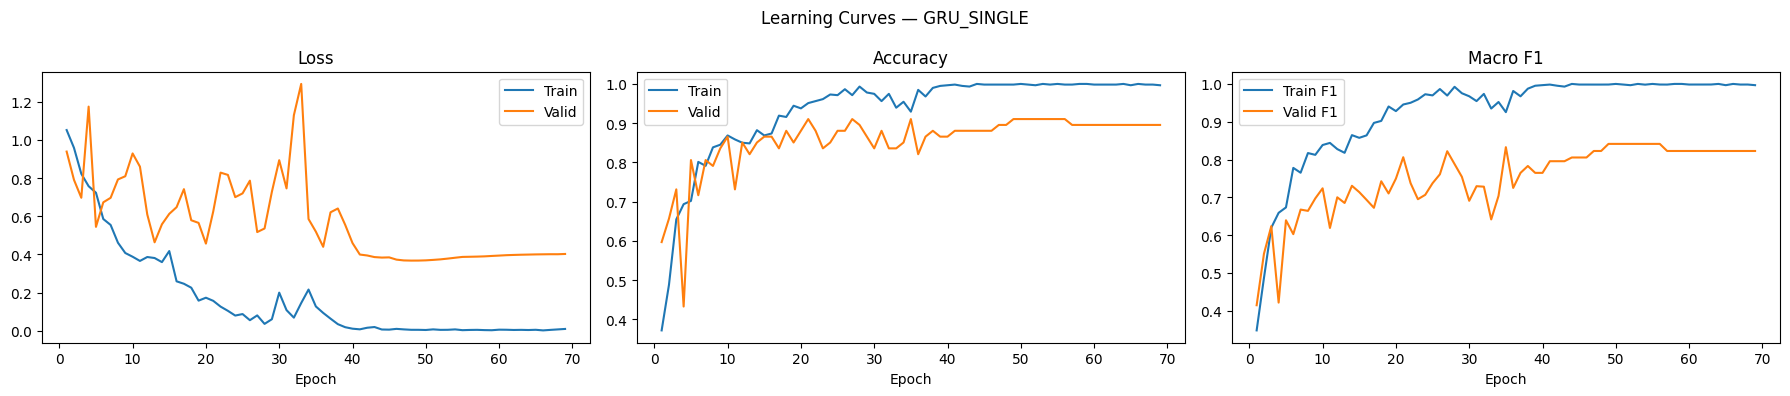

In [211]:
def plot_history(history: Dict[str, List[float]], title: str = 'Learning Curves'):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    axs[0].plot(epochs, history['train_loss'], label='Train')
    axs[0].plot(epochs, history['valid_loss'], label='Valid')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    axs[1].plot(epochs, history['train_accuracy'], label='Train')
    axs[1].plot(epochs, history['valid_accuracy'], label='Valid')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    axs[2].plot(epochs, history['train_f1'], label='Train F1')
    axs[2].plot(epochs, history['valid_f1'], label='Valid F1')
    axs[2].set_title('Macro F1')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_history(best_history, title=f"Learning Curves — {best_run['run_name']}")



Best validation macro F1: 0.836
              precision    recall  f1-score   support

   high_pain       0.62      0.83      0.71         6
    low_pain       0.80      0.89      0.84         9
     no_pain       0.98      0.92      0.95        52

    accuracy                           0.91        67
   macro avg       0.80      0.88      0.84        67
weighted avg       0.92      0.91      0.91        67



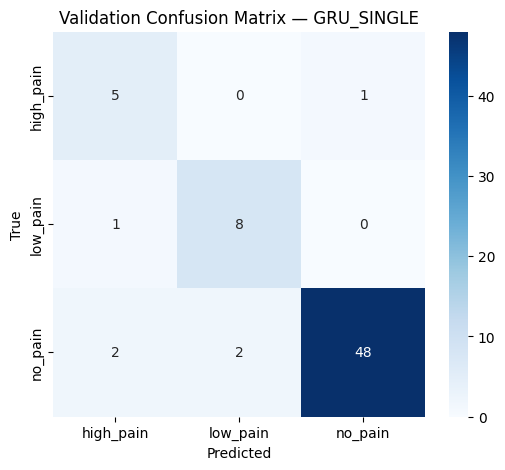

In [162]:
best_preds = best_run['preds']
best_targets = best_run['targets']
print(f"Best validation macro F1: {best_run['best_f1']:.3f}")
print(
    classification_report(
        best_targets,
        best_preds,
        target_names=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    )
)

cf = confusion_matrix(best_targets, best_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    yticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Validation Confusion Matrix — {best_run['run_name']}")
plt.show()



In [ ]:
test_loader = DataLoader(TimeSeriesDataset(X_test_np, test_context_np), batch_size=256, shuffle=False)

best_model.eval()
test_preds = []
with torch.no_grad():
    for series, context in test_loader:
        series = series.to(DEVICE)
        context = context.to(DEVICE)
        logits = best_model(series, context)
        test_preds.append(torch.argmax(logits, dim=1).cpu().numpy())

test_preds = np.concatenate(test_preds)
test_labels = [IDX2LABEL[idx] for idx in test_preds]

submission = pd.DataFrame({
    'sample_index': test_sample_ids,
    'label': test_labels,
})
submission_filename = OUTPUT_DIR / f"submission_{best_run['run_name'].lower()}.csv"
submission.to_csv(submission_filename, index=False)
print(f"Saved submission to {submission_filename}")
submission.head()



In [ ]:
%tensorboard --logdir "/content/drive/MyDrive/[2025-2026]\ AN2DL/Challenge/outputs/logs"

## Next Steps

- Espandere `EXPERIMENT_CONFIGS` con ricerche random/grid su hidden size, depth, dropout, learning rate e scheduler per automatizzare l'hyperparameter tuning.
- Utilizzare `run_cross_validation` su più configurazioni e confrontare le metriche aggregate in `cv_summary`, esportando i risultati (CSV/LaTeX) per il report finale.
- Monitorare tutti i run con `%tensorboard --logdir outputs/logs`, salvando screenshot delle curve principali e confrontando tempi/risorse.
- Integrare tecniche di regularizzazione avanzate (label smoothing, mixup temporale, stochastic weight averaging) o layer di attention/pooling.
- Costruire ensemble sui checkpoint migliori (media delle probabilità o voting) prima della submission Kaggle definitiva.

